# **Progetto Machine Learning A.A. 2023/24 - Basili Matteo**

## **Università degli studi di Roma "Tor Vergata" - Dipartimento di Ingegneria Civile e Ingegneria Informatica**

# Traccia

**A2 - Predizione del prezzo di automobili**

L’obiettivo del progetto è addestrare e valutare uno o più modelli di regressione per predire il prezzo di vendita di automobili usate.

Il progetto si basa su un dataset contenente circa 40,000 esempi di automobili usate vendute nel Regno Unito, fornito tramite il file CSV `car_prices.csv`. Il dataset contiene le seguenti colonne:

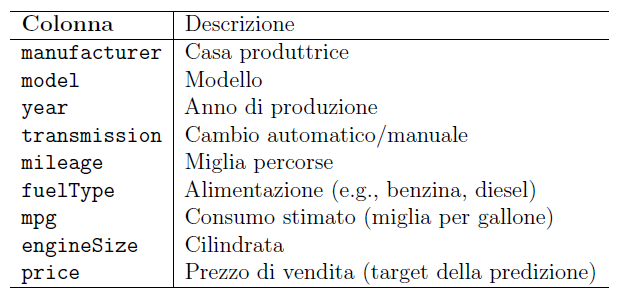

# Setup

Innanzitutto, importiamo alcuni moduli comuni e settiamo lo stile delle figure.

In [83]:
# Importazioni comuni
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Per settare seaborn come stile delle figure
import seaborn as sns
sns.set()

# Per rendere identico l'output di questo notebook ad ogni esecuzione
np.random.seed(42)

# Otteniamo i Dati

## Scarichiamo i Dati (se necessario)

In [84]:
DATASET_FILENAME="car_prices.csv"
DATASET_DIR="./data/"
DATASET_URL = "https://raw.githubusercontent.com/MatteoBasili/ml-project2324/master/dataset/car_prices.tgz"

def fetch_car_prices_data(car_prices_path=".", car_prices_url=DATASET_URL):
    import tarfile
    import urllib.request
    if not os.path.isdir(car_prices_path):
        os.makedirs(car_prices_path)
    tgz_path = os.path.join(car_prices_path, "car_prices.tgz")
    urllib.request.urlretrieve(car_prices_url, tgz_path)
    car_prices_tgz = tarfile.open(tgz_path)
    car_prices_tgz.extractall(path=car_prices_path)
    car_prices_tgz.close()

if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILENAME)):
    fetch_car_prices_data(car_prices_path=DATASET_DIR)

## Diamo una rapida occhiata alla struttura dei Dati

In [85]:
car_prices = pd.read_csv(os.path.join(DATASET_DIR, DATASET_FILENAME))
car_prices.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0,17300


In [86]:
car_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41306 entries, 0 to 41305
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  41306 non-null  object 
 1   model         41306 non-null  object 
 2   year          41306 non-null  int64  
 3   transmission  41306 non-null  object 
 4   mileage       41306 non-null  int64  
 5   fuelType      41306 non-null  object 
 6   mpg           41306 non-null  float64
 7   engineSize    41306 non-null  float64
 8   price         41306 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 2.8+ MB


Notiamo subito che non ci sono valori mancanti.

In [87]:
car_prices.describe()

,year,mileage,mpg,engineSize,price
count,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000
mean,2017.099622,23766.754733,55.634063,1.962366,21734.069651
std,2.247246,22627.617263,20.721036,0.602423,11738.947127
min,1970.000000,1.000000,1.100000,0.000000,650.000000
25%,2016.000000,6215.500000,45.600000,1.500000,13900.000000
50%,2017.000000,17467.500000,54.300000,2.000000,19750.000000
75%,2019.000000,34221.250000,64.200000,2.100000,26888.000000
max,2020.000000,323000.000000,470.800000,6.600000,159999.000000


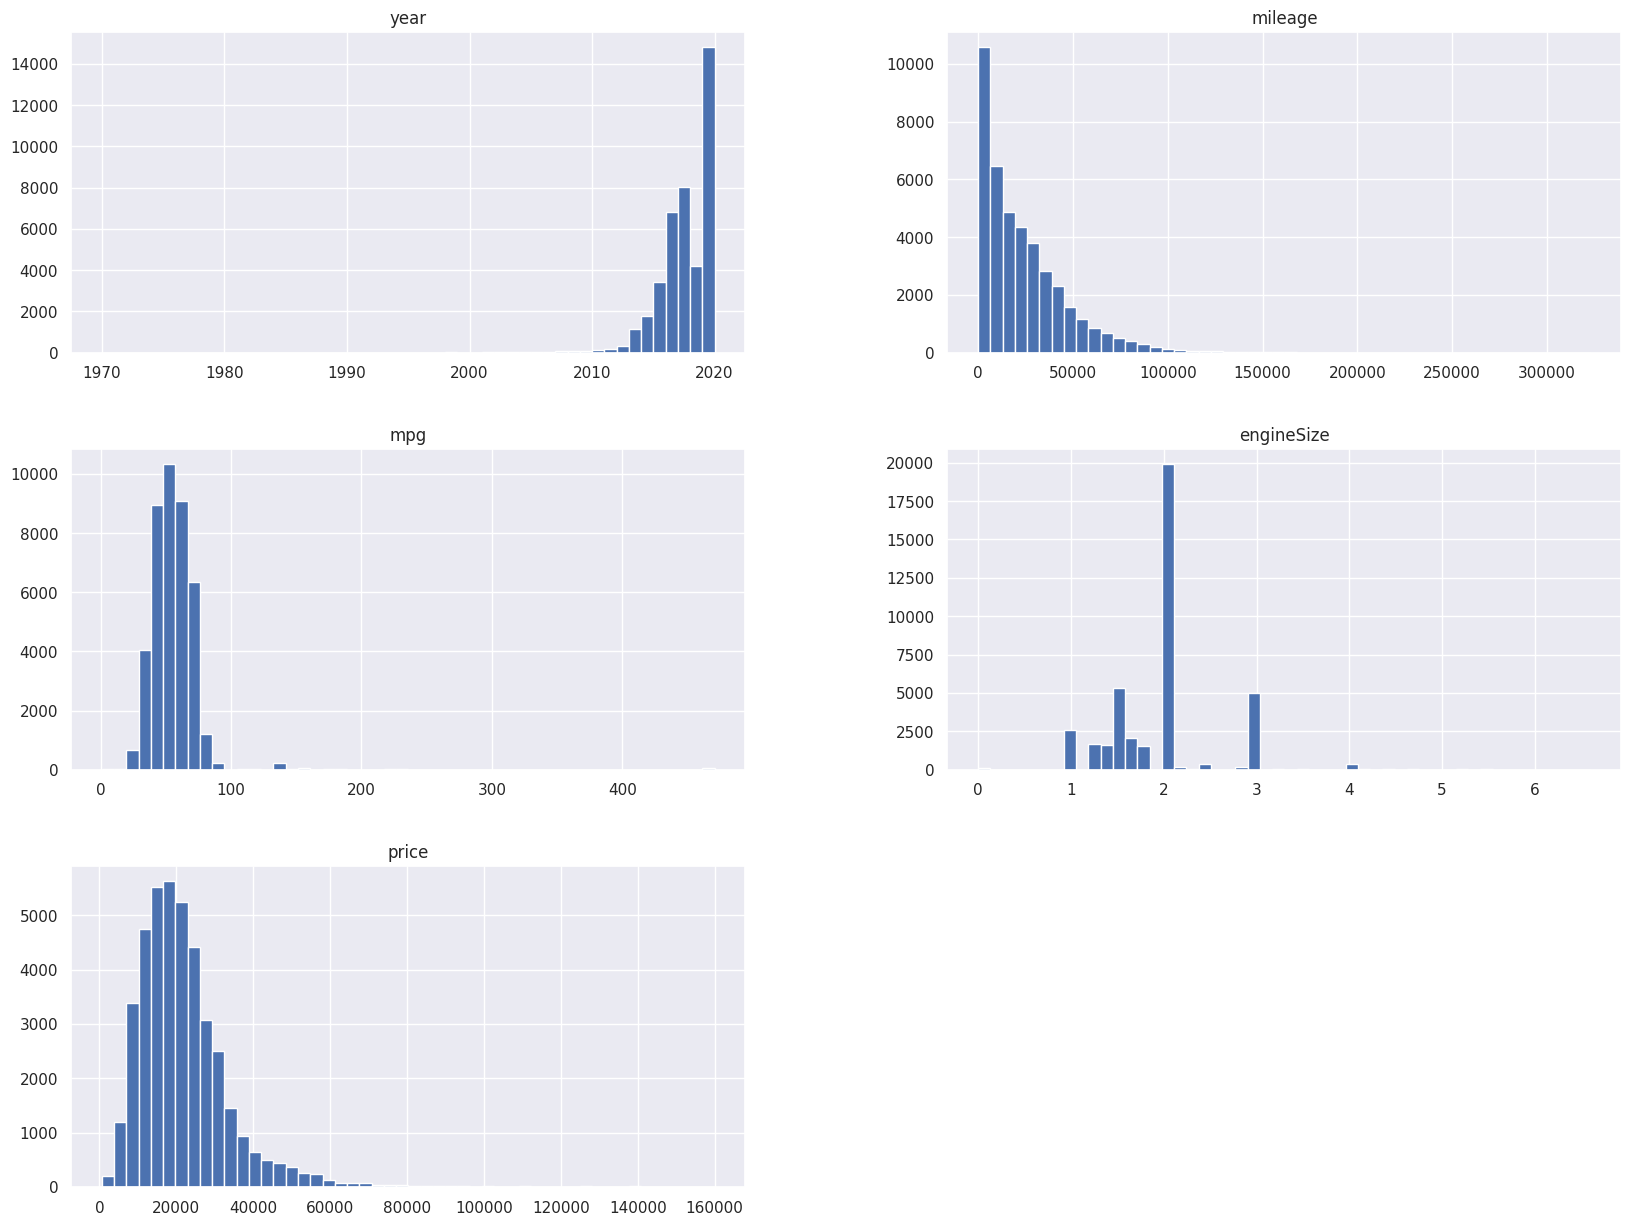

In [88]:
car_prices.hist(bins=50, figsize=(20,15))
plt.show()

Da questi grafici possiamo subito notare la presenza di outlier, che dopo affronteremo.

# Preelaboriamo i Dati

Ipotesi iniziali:
*   più miglia ha percorso una macchina e più il suo prezzo di vendita scende;
*   macchine con un motore più grande hanno un prezzo di vendita più grande;
*   più l'auto è vecchia e più sarà economica;
*   più una macchina consuma e più il suo prezzo scende.



## Analisi Esplorativa dei Dati (EDA)

Esploriamo le varie colonne e otteniamo informazioni sull'utilità di ciascuna colonna.

### Produttore

Text(0, 0.5, 'Count of cars')

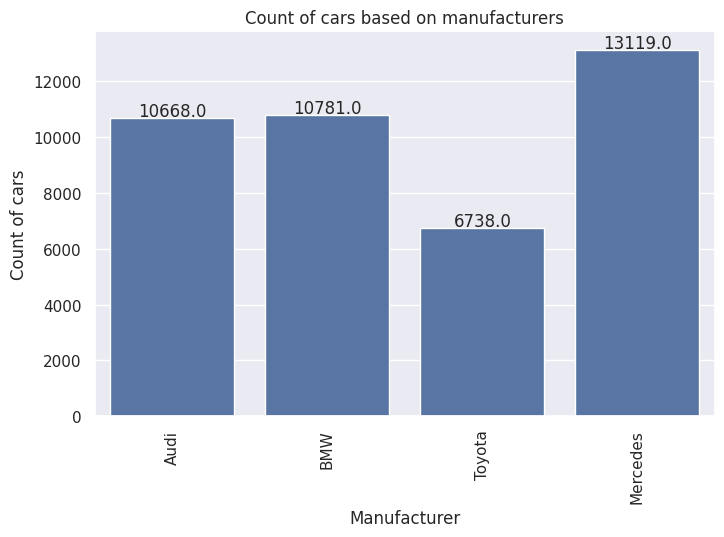

In [89]:
plt.figure(figsize = (8, 5))
plot = sns.countplot(x = 'manufacturer', data = car_prices)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(),
                        (p.get_x() + p.get_width() / 2.0,
                         p.get_height()),
                        ha = 'center',
                        va = 'center',
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Count of cars")

Il numero massimo di auto nel set di dati appartiene al produttore **Mercedes**.

### Anno

L'anno di per sé non ha alcun significato, a meno che non proviamo a estrarre quanti anni ha un'auto da questo e vediamo come il suo prezzo di vendita potrebbe essere influenzato.

In [90]:
import datetime

curr_time = datetime.datetime.now()
car_prices['year'] = car_prices['year'].apply(lambda x : curr_time.year - x)

In [91]:
# Rinominiamo la colonna
car_prices = car_prices.rename(columns={'year': 'age'})

car_prices.head()

,manufacturer,model,age,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,7,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,8,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,8,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,7,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,5,Manual,1998,Petrol,49.6,1.0,17300


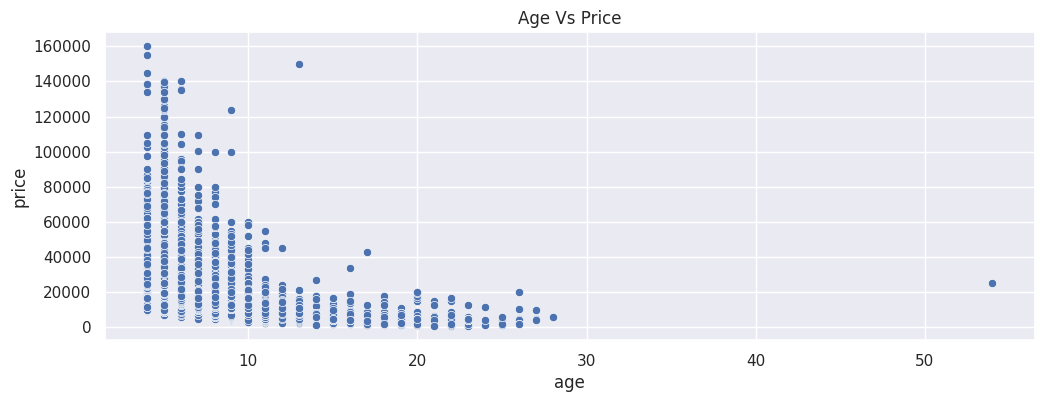

In [92]:
# Tracciamo il grafico del prezzo rispetto all'età delle auto
plt.figure(figsize=(12,4))

sns.scatterplot(x=car_prices['age'], y=car_prices['price']);
plt.title('Age Vs Price');

Notiamo che più l'auto è vecchia e più il prezzo è basso, il che conferma una delle nostre ipotesi iniziali.

### Miglia percorse

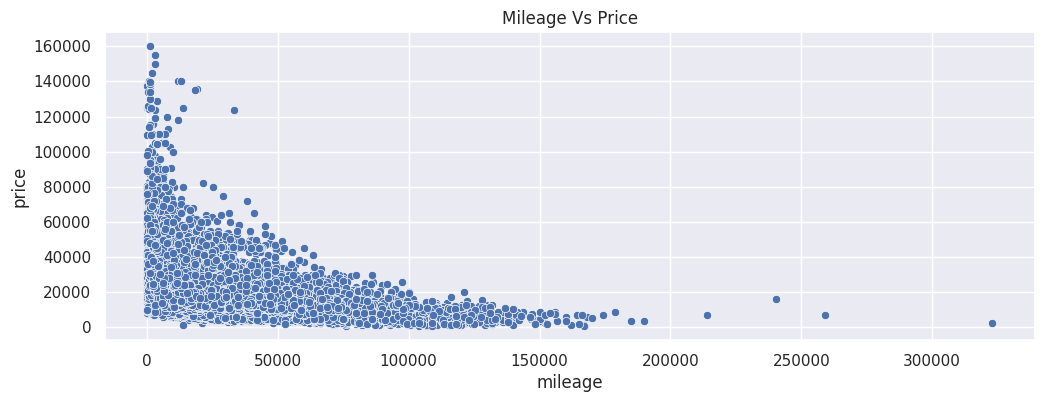

In [93]:
# Tracciamo il grafico del prezzo rispetto alle miglia percorse
plt.figure(figsize=(12,4))

sns.scatterplot(x=car_prices['mileage'], y=car_prices['price']);
plt.title('Mileage Vs Price');

Notiamo anche qui che più un auto è stata guidata e più il suo prezzo è basso.

### Consumo

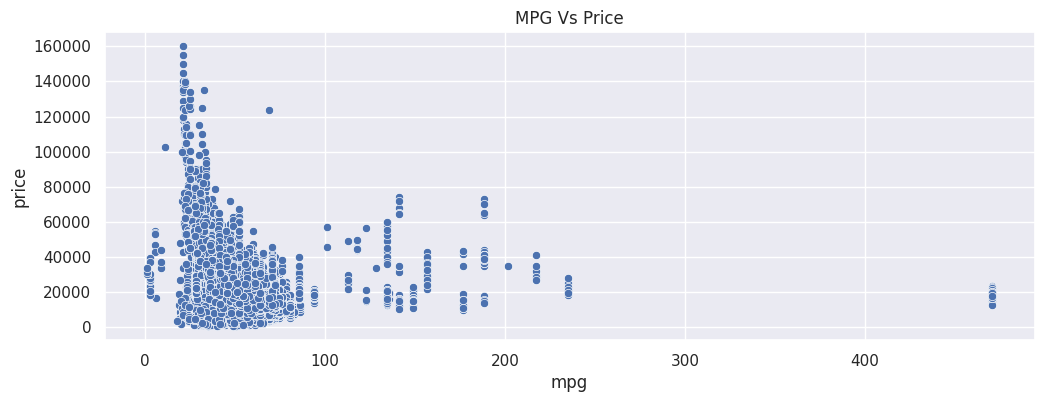

In [94]:
# Tracciamo il grafico del prezzo rispetto al consumo
plt.figure(figsize=(12,4))

sns.scatterplot(x=car_prices['mpg'], y=car_prices['price']);
plt.title('MPG Vs Price');

Anche in questo caso si nota abbastanza lo stesso fatto.

### Motore

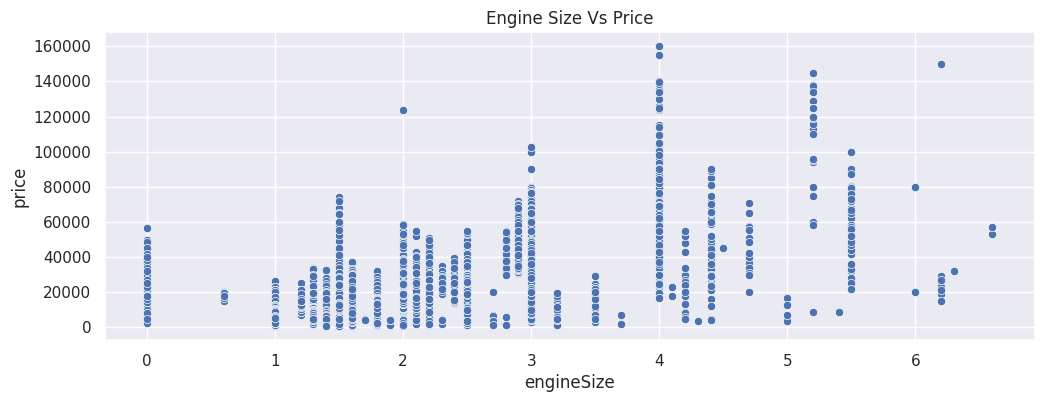

In [95]:
# Tracciamo il grafico del prezzo rispetto alla dimensione del motore
plt.figure(figsize=(12,4))

sns.scatterplot(x=car_prices['engineSize'], y=car_prices['price']);
plt.title('Engine Size Vs Price');

Qui, invece, si può vedere l'effetto contrario, anche se non si nota tantissimo.

Quello che emerge da questi ultimi grafici è che le relazioni tra le caratteristiche esaminate e il prezzo delle auto sono tutto tranne che lineari. Dovremo fare qualcosa, poi, per gestire questa situazione.

### Modello, Cambio e Carburante

In [96]:
car_prices["model"].value_counts()

model
 C Class     3747
 A Class     2561
 3 Series    2443
 Yaris       2122
 1 Series    1969
             ... 
 RS7            1
180             1
230             1
220             1
200             1
Name: count, Length: 95, dtype: int64

In [97]:
car_prices["transmission"].value_counts()

transmission
Semi-Auto    15359
Automatic    13778
Manual       12166
Other            3
Name: count, dtype: int64

In [98]:
car_prices["fuelType"].value_counts()

fuelType
Diesel      22294
Petrol      16319
Hybrid       2542
Other         148
Electric        3
Name: count, dtype: int64

Tutte queste colonne (insieme anche a quella del `manufacturer`) sono colonne categoriche che devono essere convertite prima di essere utilizzate.

## Affrontiamo gli Outlier

Gli outlier (o valori anomali) sono osservazioni nei dati che si discostano significativamente dalle altre osservazioni. Questi valori possono essere molto più alti o molto più bassi rispetto alla maggior parte dei dati e possono derivare da vari motivi, come errori di misurazione, variabilità naturale dei dati o eventi eccezionali.

Quello che faremo noi è di eliminare questi outlier.

### Prezzo

Prendiamo il 99% dei dati totali e rimuoviamo l'1%.
A questo scopo, usiamo il metodo Pandas `.quantile()`.

In [99]:
q = car_prices['price'].quantile(q = 0.99) # ritorna un singolo valore
q

60122.74999999993

In [100]:
# rimuoviamo gli outlier
car_1 = car_prices[car_prices['price']<q]

car_1.describe()

,age,mileage,mpg,engineSize,price
count,40892.000000,40892.000000,40892.000000,40892.000000,40892.000000
mean,6.919691,23960.269906,55.857556,1.945036,21176.533503
std,2.248432,22652.335870,20.574257,0.574361,10214.400458
min,4.000000,1.000000,1.100000,0.000000,650.000000
25%,5.000000,6432.750000,46.300000,1.500000,13799.000000
50%,7.000000,17789.500000,55.000000,2.000000,19511.500000
75%,8.000000,34464.250000,64.200000,2.000000,26491.250000
max,54.000000,323000.000000,470.800000,6.600000,60099.000000


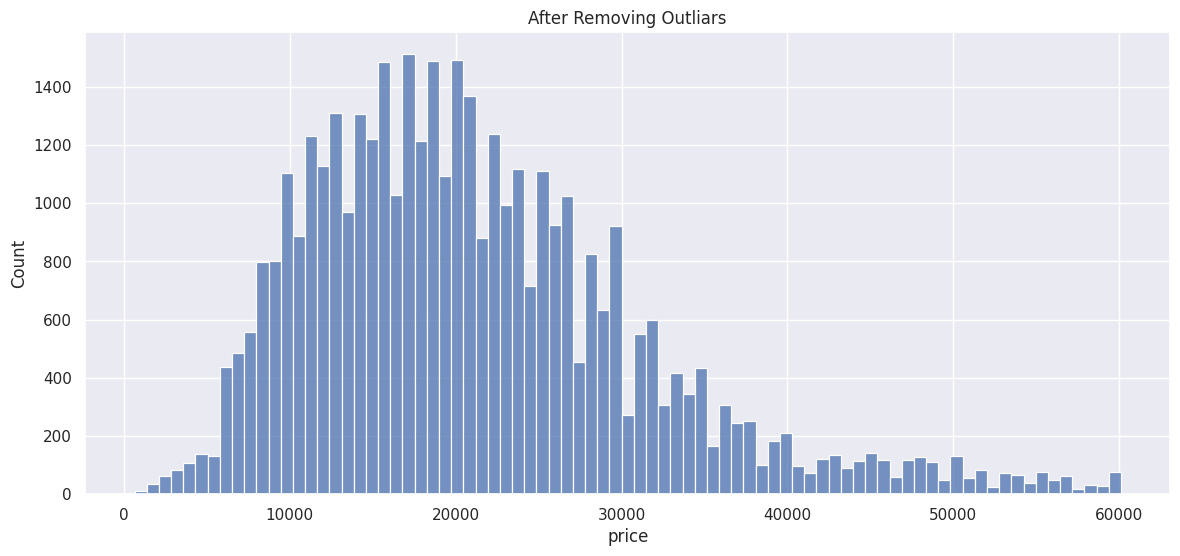

In [101]:
plt.figure(figsize=(14,6))

sns.histplot(car_1['price']);
plt.title('After Removing Outliars');

### Età

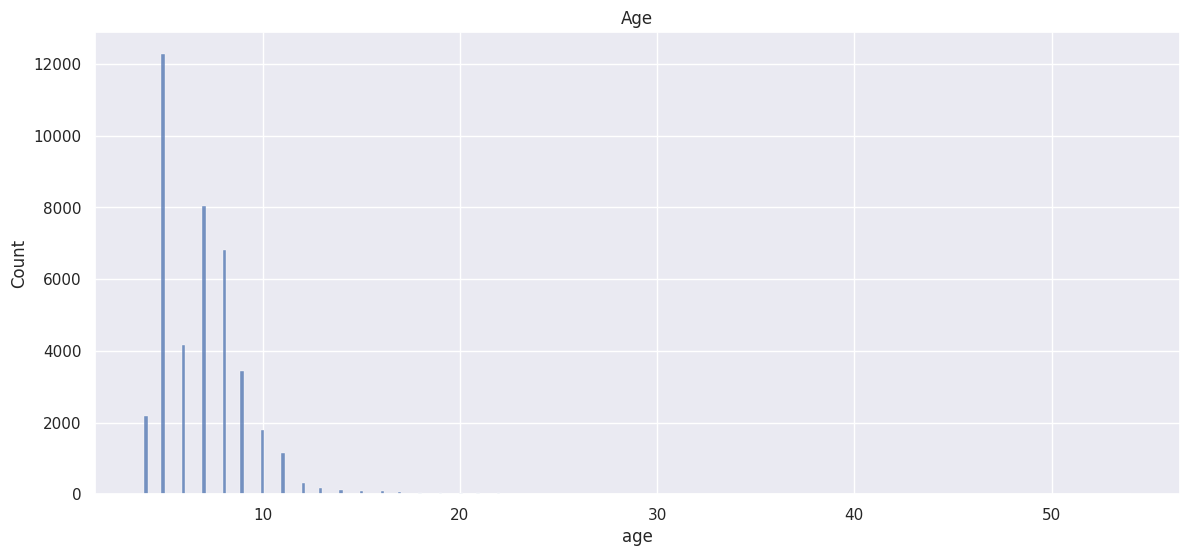

In [102]:
# Tracciamo il grafico
plt.figure(figsize=(14,6))

sns.histplot(car_1['age']);
plt.title('Age');

Vediamo che la maggior parte delle auto sono recenti (hanno meno di 10 anni), ma ci sono anche alcune che ne hanno più di 20.

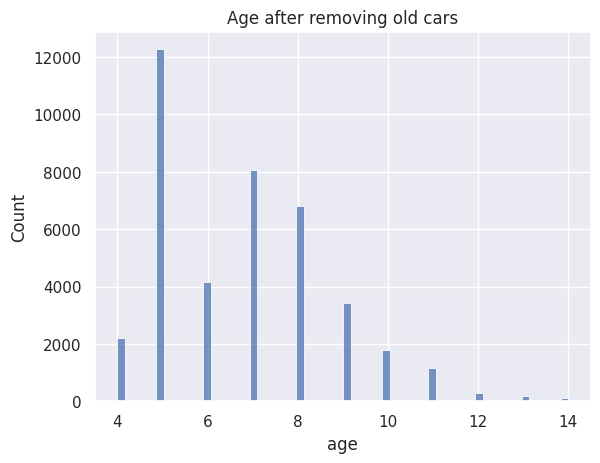

In [103]:
# eliminiamo le auto più vecchie
q = car_1['age'].quantile(0.99);
car_2 = car_1[car_1['age']<q]

# tracciando ancora il grafico
sns.histplot(car_2['age']);
plt.title('Age after removing old cars');

### Mileage e MPG

Facciamo la stessa cosa per le miglia percorse e per il consumo.

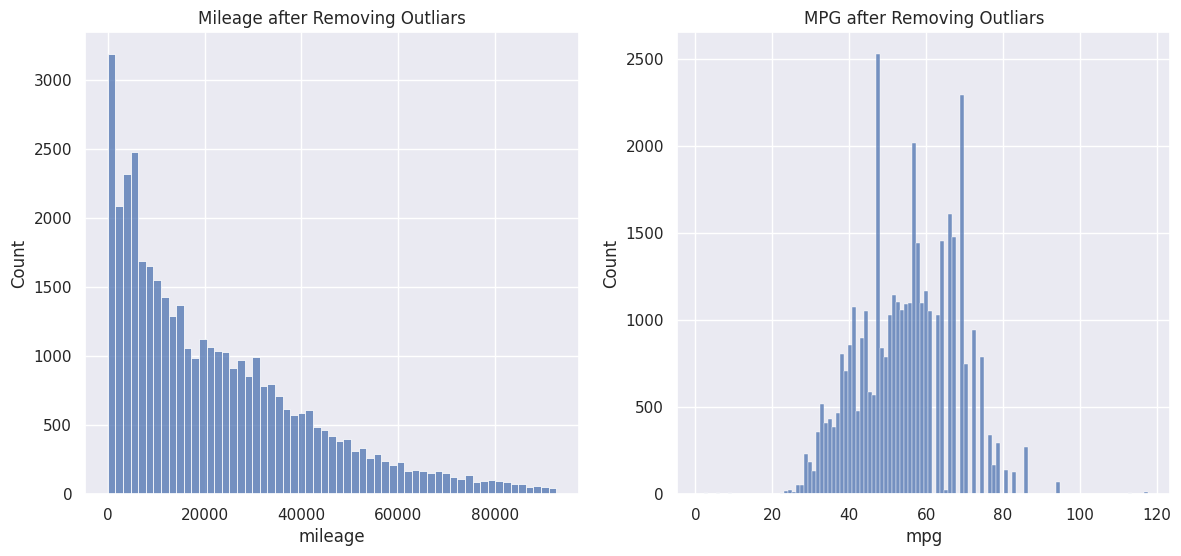

In [104]:
plt.figure(figsize=(14,6))

# mileage
q = car_2['mileage'].quantile(0.99)
car_3 = car_2[car_2['mileage']<q]

plt.subplot(1,2,1)
sns.histplot(car_3['mileage']);
plt.title('Mileage after Removing Outliars');

# mpg
q = car_3['mpg'].quantile(0.99)
car_4 = car_3[car_3['mpg']<q]

plt.subplot(1,2,2)
sns.histplot(car_4['mpg']);
plt.title('MPG after Removing Outliars');

In [105]:
# Diamo un'occhiata ai dati adesso
car_4

,manufacturer,model,age,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,7,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,8,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,8,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,7,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,5,Manual,1998,Petrol,49.6,1.0,17300
...,...,...,...,...,...,...,...,...,...
41301,Mercedes,C Class,4,Automatic,500,Diesel,55.4,2.0,35999
41302,Mercedes,B Class,4,Automatic,2500,Diesel,55.4,2.0,24699
41303,Mercedes,GLC Class,5,Automatic,11612,Diesel,41.5,2.1,30999
41304,Mercedes,CLS Class,5,Automatic,2426,Diesel,45.6,2.0,37990


Da qui si può vedere che l'indice è un po' incasinato.  L'ultimo valore dell'indice non corrisponde al numero totale di righe. Questo perché abbiamo rimosso alcune righe dai dati, ma l'indice viene mostrato dai dati grezzi.


In [106]:
# resettiamo gli indici
car_prices_clean = car_4.reset_index(drop=True)

# controlliamo i dati
car_prices_clean

,manufacturer,model,age,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,7,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,8,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,8,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,7,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,5,Manual,1998,Petrol,49.6,1.0,17300
...,...,...,...,...,...,...,...,...,...
39635,Mercedes,C Class,4,Automatic,500,Diesel,55.4,2.0,35999
39636,Mercedes,B Class,4,Automatic,2500,Diesel,55.4,2.0,24699
39637,Mercedes,GLC Class,5,Automatic,11612,Diesel,41.5,2.1,30999
39638,Mercedes,CLS Class,5,Automatic,2426,Diesel,45.6,2.0,37990


Ora le righe corrispondono.

In [107]:
car_prices_clean.describe(include='all')

,manufacturer,model,age,transmission,mileage,fuelType,mpg,engineSize,price
count,39640,39640,39640.000000,39640,39640.000000,39640,39640.000000,39640.000000,39640.000000
unique,4,89,NaN,4,NaN,4,NaN,NaN,NaN
top,Mercedes,C Class,NaN,Semi-Auto,NaN,Diesel,NaN,NaN,NaN
freq,12602,3555,NaN,14981,NaN,21611,NaN,NaN,NaN
mean,NaN,NaN,6.761630,NaN,22308.482190,NaN,54.685711,1.942162,21460.436655
std,NaN,NaN,1.875812,NaN,19632.463998,NaN,12.420934,0.569357,10111.024541
min,NaN,NaN,4.000000,NaN,1.000000,NaN,1.100000,0.000000,2395.000000
25%,NaN,NaN,5.000000,NaN,6184.750000,NaN,46.300000,1.500000,13999.000000
50%,NaN,NaN,7.000000,NaN,17000.000000,NaN,55.000000,2.000000,19890.000000
75%,NaN,NaN,8.000000,NaN,33015.000000,NaN,64.200000,2.000000,26750.000000


In [108]:
car_prices.shape[0] -  car_prices_clean.shape[0]

1666

Abbiamo rimosso un totale di 1666 righe dai dati grezzi.

## Trasformiamo il target

Abbiamo visto in precedenza che le relazioni tra il prezzo delle auto e le caratteristiche non è lineare.

Un approccio comune adottato da molti per linearizzare le relazioni è la `trasformazione logaritmica`. Questo metodo è molto utile per ulteriori aspetti, come la riduzione della varianza, la stabilità numerica (perchè si lavora con numeri più piccoli) e l'interpretabilità dei parametri.

`Numpy` ha un metodo che calcola il logaritmo naturale di un numero o di un array, ovvero `np.log(x)`.

In [109]:
# trasformiamo il prezzo
log_price = np.log(car_prices_clean['price'])

# aggiungiamo la colonna
car_prices_clean['log_price'] = log_price

car_prices_clean.head()

,manufacturer,model,age,transmission,mileage,fuelType,mpg,engineSize,price,log_price
0,Audi,A1,7,Manual,15735,Petrol,55.4,1.4,12500,9.433484
1,Audi,A6,8,Automatic,36203,Diesel,64.2,2.0,16500,9.711116
2,Audi,A1,8,Manual,29946,Petrol,55.4,1.4,11000,9.305651
3,Audi,A4,7,Automatic,25952,Diesel,67.3,2.0,16800,9.729134
4,Audi,A3,5,Manual,1998,Petrol,49.6,1.0,17300,9.758462


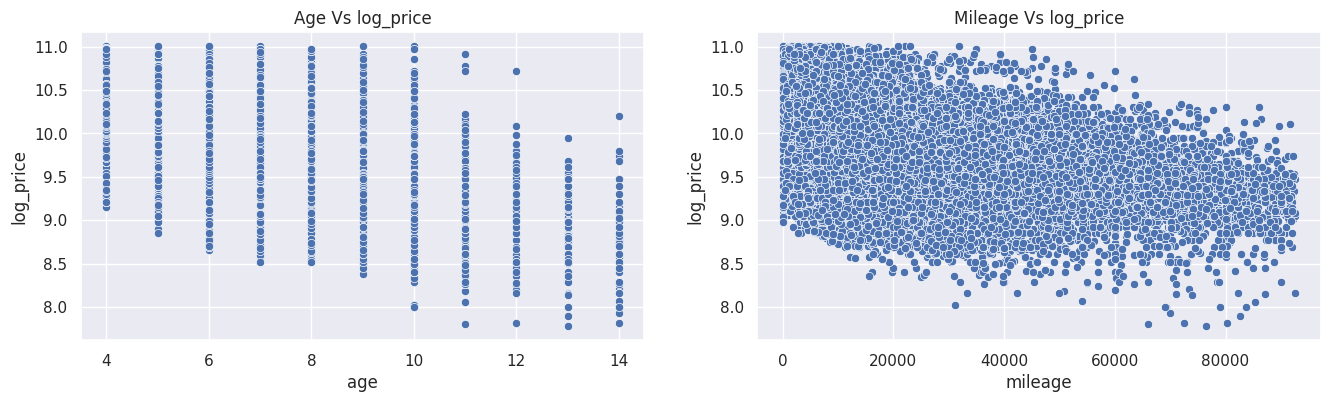

In [110]:
# ritracciamo di nuovo i grafici delle relazioni con il prezzo usando, adesso, il logaritmo
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.scatterplot(x=car_prices_clean['age'], y=car_prices_clean['log_price']);
plt.title('Age Vs log_price');

plt.subplot(1,2,2)
sns.scatterplot(x=car_prices_clean['mileage'], y=car_prices_clean['log_price']);
plt.title('Mileage Vs log_price');

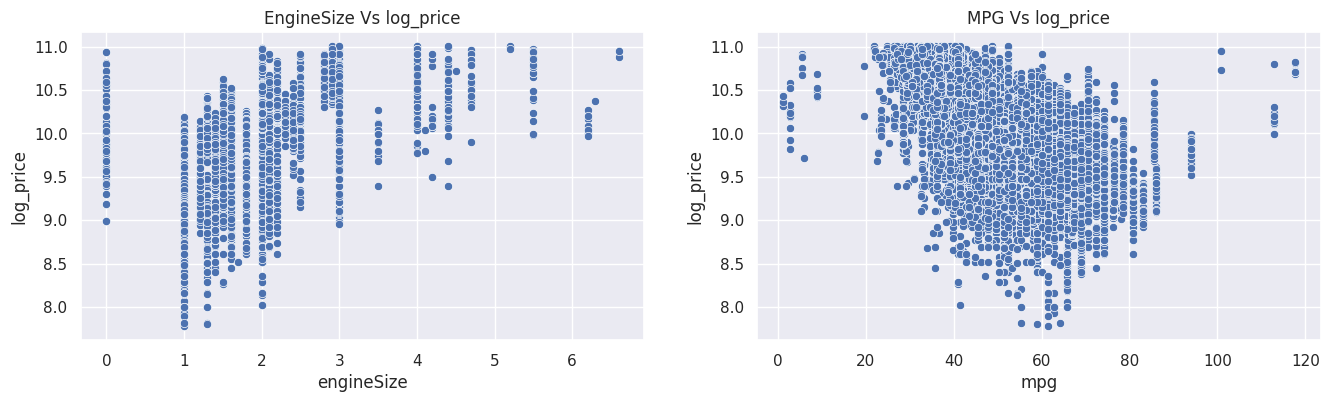

In [111]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,2)
sns.scatterplot(x=car_prices_clean['mpg'], y=car_prices_clean['log_price']);
plt.title('MPG Vs log_price');

plt.subplot(1,2,1)
sns.scatterplot(x=car_prices_clean['engineSize'], y=car_prices_clean['log_price']);
plt.title('EngineSize Vs log_price');

Ora le cose sono cambiate. Possiamo osservare di più la linearità dei dati con la colonna logaritmica del prezzo.

In [112]:
# eliminiamo la colonna originaria del prezzo che non è più necessaria
car_prices_clean.drop('price', axis=1, inplace=True)

## Multicollinearità

La multicollinearità è un problema che si verifica quando due o più variabili indipendenti in un modello di regressione sono altamente correlate.
Questo può portare a instabilità nelle stime dei coefficienti, rendendo difficile interpretare i risultati del modello e riducendo l'affidabilità delle previsioni.

In questo caso, ci può essere una certa multicollinearità nei dati, come ad esempio il fatto che più nuova è l'auto, minore sarà il chilometraggio. Quindi, `year` e `mileage` saranno correlati.

Usiamo il VIF (Fattore di Inflazione della Varianza), per verificare la multicollinearità.

In [113]:
# importiamo VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# prendiamo solo le colonne numeriche
var = car_prices_clean[['age', 'mileage', 'mpg', 'engineSize']]

# creiamo un dataframe
vif_df = pd.DataFrame()
vif_df['VIF'] = [vif(var.values, i) for i in range(var.shape[1])]
vif_df['features'] = var.columns

# controlliamo il risultato
vif_df

,VIF,features
0,28.305722,age
1,4.698565,mileage
2,13.726871,mpg
3,8.115650,engineSize


Un VIF superiore a 10 è spesso considerato indicativo di multicollinearità, ma alcuni esperti suggeriscono soglie più basse, come 5.

Dai risultati ottenuti, sembra che le colonne `age` e `mpg` siano troppo correlata con le altre colonne. Potremmo eliminarne una delle due ad esempio. Però, entrambe sono molto rilevanti per il problema. Quindi, decidiamo di lasciarle.

## Variabili categoriche

`manufacturer`, `model`, `transmission` e `fuelType`

Per gestire le variabili categoriche, utilizzeremo la tecnica del `Label Encoding`.
Label Encoding trasforma ogni categoria unica di una variabile categorica in un numero intero.

In [114]:
# Creiamo un dizionario per tutte le variabili categoriche
manufacturer_dic = dict()
model_dic = dict()
transmission_dic = dict()
fuel_type_dic = dict()

In [115]:
from sklearn.preprocessing import LabelEncoder
# crea un'istanza del labelEncoder
le = LabelEncoder()

# colonna manufacturer
car_prices_clean['manufacturer_enc'] = le.fit_transform(car_prices_clean['manufacturer'])
for num, lbl in enumerate(le.classes_):
  manufacturer_dic[lbl] = num

# colonna model
car_prices_clean['model_enc'] = le.fit_transform(car_prices_clean['model'])
for num, lbl in enumerate(le.classes_):
  model_dic[lbl] = num

# colonna transmission
car_prices_clean['transmission_enc'] = le.fit_transform(car_prices_clean['transmission'])
for num, lbl in enumerate(le.classes_):
  transmission_dic[lbl]=num

# colonna fuel type
car_prices_clean['fuel_type_enc'] = le.fit_transform(car_prices_clean['fuelType'])
for num, lbl in enumerate(le.classes_):
  fuel_type_dic[lbl]=num

# eliminiamo le colonne originali
car_clean_2 = car_prices_clean.drop(['manufacturer', 'model', 'transmission', 'fuelType'], axis=1)

car_clean_2.head()

,age,mileage,mpg,engineSize,log_price,manufacturer_enc,model_enc,transmission_enc,fuel_type_enc
0,7,15735,55.4,1.4,9.433484,0,9,1,3
1,8,36203,64.2,2.0,9.711116,0,13,0,0
2,8,29946,55.4,1.4,9.305651,0,9,1,3
3,7,25952,67.3,2.0,9.729134,0,11,0,0
4,5,1998,49.6,1.0,9.758462,0,10,1,3


Controlliamo ora la multicollinearità per tutte le colonne.

In [116]:
# creiamo un dataframe
vif_df_all = pd.DataFrame()
vif_df_all['VIF'] = [vif(car_clean_2.values, i) for i in range(car_clean_2.shape[1])]
vif_df_all['features'] = car_clean_2.columns

# controlliamo il risultato
vif_df_all

,VIF,features
0,35.352694,age
1,6.373100,mileage
2,42.933857,mpg
3,29.193723,engineSize
4,104.989302,log_price
5,3.524796,manufacturer_enc
6,2.422538,model_enc
7,2.427610,transmission_enc
8,3.012745,fuel_type_enc


Il valore VIF per `log_price` (la nostra colonna target), è 104, il che ci indica che il prezzo è altamente correlato con altre colonne. Questo è un segno molto positivo.

## Scaliamo i Dati

In [117]:
# Dichiarazione delle feature e della variabile target
X = car_clean_2.drop('log_price', axis=1)
y = car_clean_2['log_price']

X.shape, y.shape

((39640, 8), (39640,))

In [118]:
from sklearn.preprocessing import StandardScaler

# crea un'istanza dello scaler
scaler = StandardScaler()

# scaliamo i dati
X_scaled = scaler.fit_transform(X)

X_scaled

array([[ 0.12707739, -0.33483138,  0.05750756, ..., -0.7189743 ,
        -0.3348307 ,  1.21262256],
       [ 0.66018648,  0.70774066,  0.76599784, ..., -0.56256661,
        -1.11283122, -0.86991156],
       [ 0.66018648,  0.38902983,  0.05750756, ..., -0.7189743 ,
        -0.3348307 ,  1.21262256],
       ...,
       [-0.93914079, -0.54484333, -1.06158504, ...,  0.21947188,
        -1.11283122, -0.86991156],
       [-0.93914079, -1.01274771, -0.73149298, ..., -0.09334351,
        -1.11283122, -0.86991156],
       [-0.93914079, -1.03062649, -0.19207424, ...,  1.31432576,
        -1.11283122, -0.86991156]])

## Divisione in Training, Validation e Test Set

In [119]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((23784, 8), (23784,), (7928, 8), (7928,), (7928, 8), (7928,))

Ora siamo pronti per creare i nostri modelli.

# Regressione Lineare

Utilizziamo la Regressione Lineare come primo modello.

In [120]:
# Creiamo la regressione
from sklearn.linear_model import LinearRegression

# creiamo un'istanza del modello
reg = LinearRegression()

# addestriamo i dati
model = reg.fit(X_train, y_train)

## Valutiamo il modello sul Validation Set

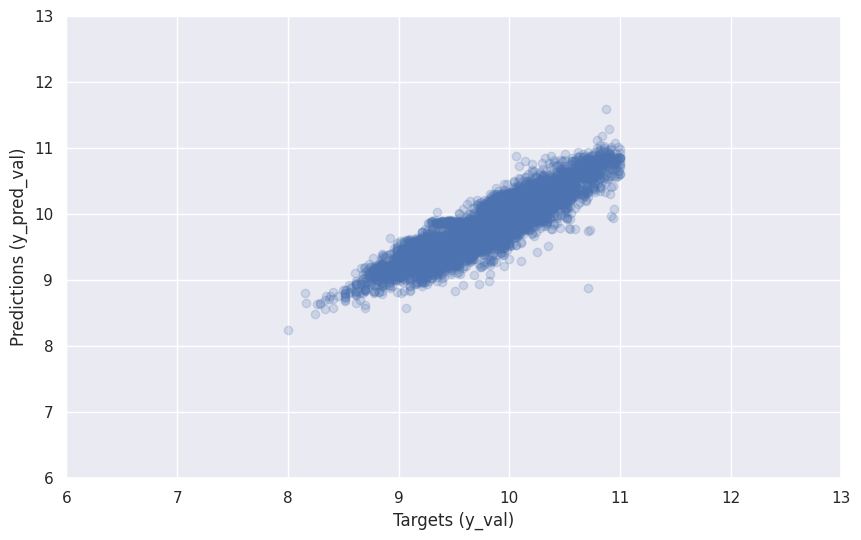

In [121]:
# Controlliamo le predizioni con i valori target
y_pred_val = reg.predict(X_val)
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_pred_val, alpha=0.2);
plt.xlabel('Targets (y_val)');
plt.ylabel('Predictions (y_pred_val)');
plt.xlim(6,13);
plt.ylim(6,13);

Le previsioni sul validation set sembrano buone, non sono completamente casuali: si può osservare la linearità nel grafico.

Un altro modo per verificare la linearità sono i `residui`, che rappresentano la differenza tra i valori target e le previsioni.

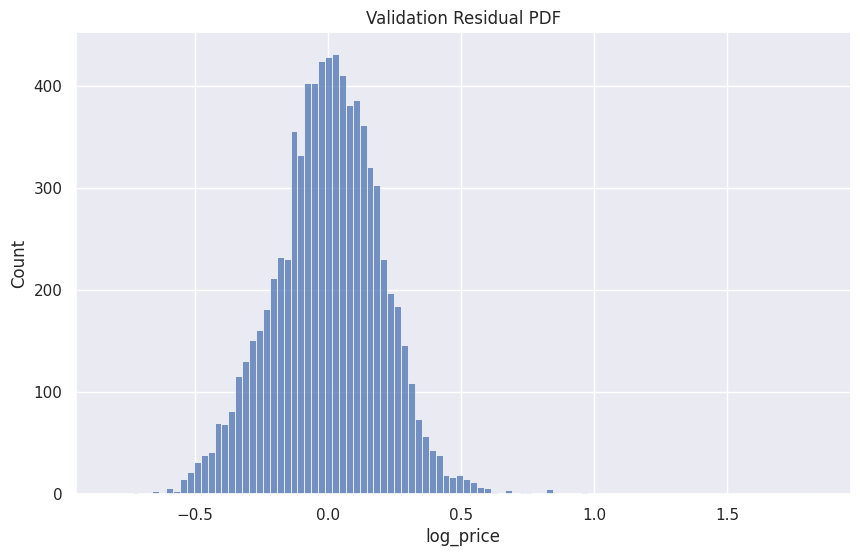

In [122]:
residual_val = (y_val - y_pred_val)

# tracciamo la distribuzione dei residui di addestramento
plt.figure(figsize=(10,6))
sns.histplot(residual_val);
plt.title('Validation Residual PDF');

Da questo grafico si può osservare che la maggior parte dei valori giacciono vicino allo `0`, indicando che le previsioni sono molto vicine ai valori target. Questo significa che il modello ha funzionato bene.

In [123]:
# Controlliamo l'r2_score
from sklearn.metrics import r2_score

r2_score(y_val, y_pred_val)

0.8177472250064768

In [124]:
# Controlliamo l'RMSE
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_pred_val))) # np.exp inverte la trasformazione logaritmica

4493.105492439748

Il nostro modello spiega l'81% della variazione nella variabile dipendente e ha un errore di `4493`. Non è così male.

## Diamo un'occhiata ai Pesi e ai Bias

In [125]:
reg_summary = pd.DataFrame(X.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,age,-0.204958
1,mileage,-0.096956
2,mpg,-0.110105
3,engineSize,0.193611
4,manufacturer_enc,-0.058385
5,model_enc,0.013397
6,transmission_enc,0.018740
7,fuel_type_enc,-0.090810


Spieghiamo i pesi ottenuti:

* `Pesi positivi`: Aumentando il valore della caratteristica, anche il prezzo aumenterà.
* `Pesi negativi`: Aumentando il valore della caratteristica, il prezzo diminuirà.

Questa è un'ulteriore conferma per le ipotesi fatte inizialmente.

## Valutiamo il modello sul Test Set

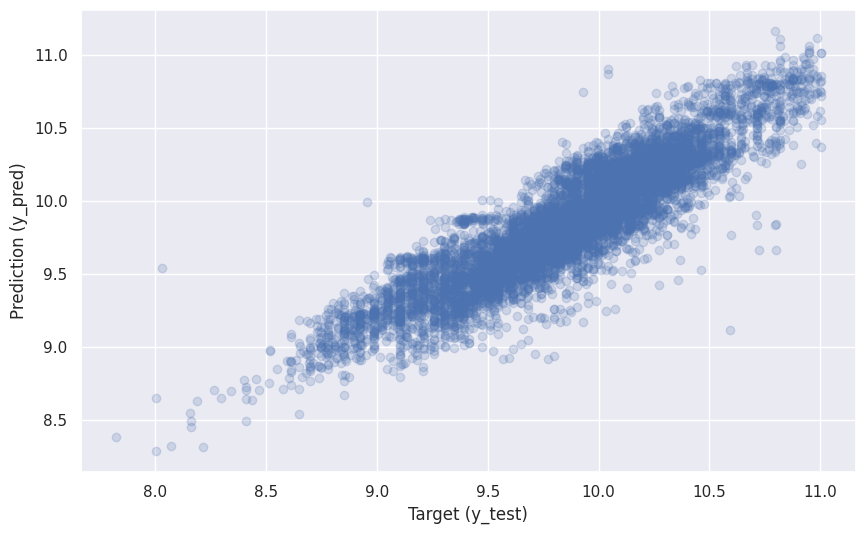

In [126]:
y_pred = reg.predict(X_test)

# tracciamo il grafico
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.2);

plt.xlabel('Target (y_test)');
plt.ylabel('Prediction (y_pred)');

In [127]:
# controlliamo l'RMSE sul test set
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))

4506.605306677819

Sul test set, il modello ha un errore di `4506`, il che indica che il modello non performa così male.

In [128]:
# Creiamo un dataframe per comparare i risultati e le predizioni.
df_eval = pd.DataFrame(np.exp(y_pred), columns=['Prediction'])

y_test = y_test.reset_index(drop=True)
df_eval['Target'] = np.exp(y_test)

df_eval

,Prediction,Target
0,12660.776223,8790.0
1,11747.868356,12450.0
2,24074.831501,17999.0
3,15005.468613,9290.0
4,29697.029233,24985.0
...,...,...
7923,13745.184919,10400.0
7924,25567.393848,33283.0
7925,9711.376513,11599.0
7926,12311.272577,9290.0


In [129]:
# Creiamo ulteriori due colonne
df_eval['Residual'] = df_eval['Target'] - df_eval['Prediction']
df_eval['Difference%'] = np.absolute(df_eval['Residual'] / df_eval['Target']*100)

df_eval

,Prediction,Target,Residual,Difference%
0,12660.776223,8790.0,-3870.776223,44.036135
1,11747.868356,12450.0,702.131644,5.639612
2,24074.831501,17999.0,-6075.831501,33.756495
3,15005.468613,9290.0,-5715.468613,61.522805
4,29697.029233,24985.0,-4712.029233,18.859433
...,...,...,...,...
7923,13745.184919,10400.0,-3345.184919,32.165240
7924,25567.393848,33283.0,7715.606152,23.181823
7925,9711.376513,11599.0,1887.623487,16.274019
7926,12311.272577,9290.0,-3021.272577,32.521772


In [130]:
df_eval.describe()

,Prediction,Target,Residual,Difference%
count,7928.000000,7928.000000,7928.000000,7928.000000
mean,20853.664218,21223.533426,369.869208,16.370511
std,9207.405845,9886.864949,4491.684869,13.926514
min,3979.369446,2495.000000,-31227.647979,0.008645
25%,14175.727790,13995.000000,-2169.847440,6.439119
50%,18929.719681,19699.000000,91.798780,13.155729
75%,26133.094092,26442.500000,2706.796841,22.830167
max,70440.097904,60000.000000,33226.830466,351.983028


## Regolarizzazione

Aggiungiamo un termine di penalizzazione alla funzione di costo del modello per evitare overfitting e per gestire la multicollinearità.

In [131]:
from sklearn.linear_model import Ridge

# Utilizzo di Ridge Regression (Regolarizzazione L2)
ridge_model = Ridge(alpha=10.0)
ridge_model.fit(X_train, y_train)

Ridge(alpha=10.0)

Rivalutiamo adesso il modello.

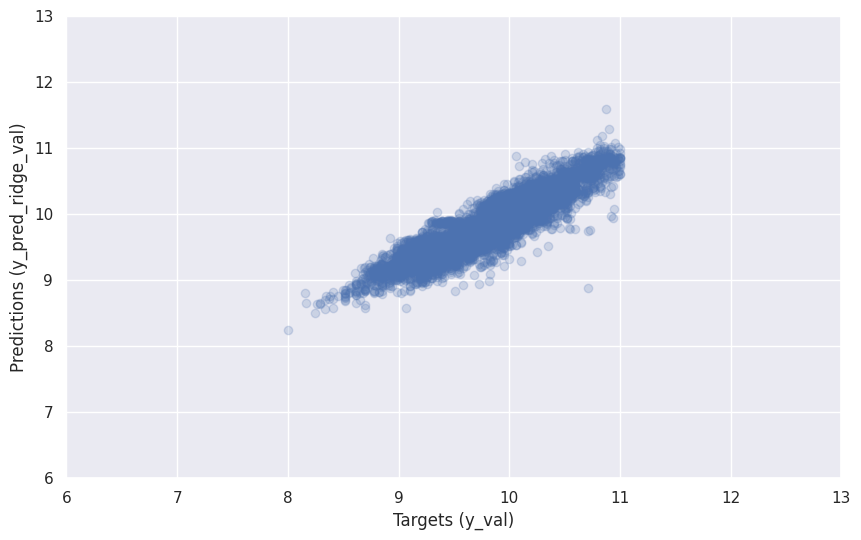

In [132]:
# validation set
y_pred_ridge_val = ridge_model.predict(X_val)
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_pred_ridge_val, alpha=0.2);
plt.xlabel('Targets (y_val)');
plt.ylabel('Predictions (y_pred_ridge_val)');
plt.xlim(6,13);
plt.ylim(6,13);

In [133]:
r2_score(y_val, y_pred_ridge_val)

0.8177471327268321

In [134]:
np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_pred_ridge_val)))

4492.723156294027

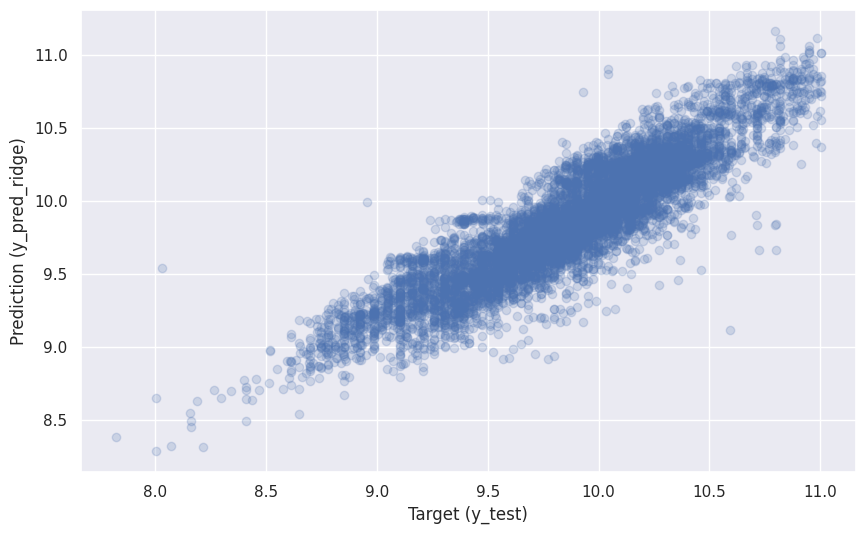

In [135]:
# test set
y_pred_ridge = ridge_model.predict(X_test)

# tracciamo il grafico
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.2);

plt.xlabel('Target (y_test)');
plt.ylabel('Prediction (y_pred_ridge)');

In [136]:
# controlliamo l'RMSE sul test set
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_ridge)))

4506.2951333816645

Notiamo che con l'aggiunta della regolarizzazione i risultati sono rimasti praticamente uguali. Ciò potrebbe significare che il nostro modello di regressione lineare standard potrebbe già adattarsi bene ai dati, e l'aggiunta della regolarizzazione non apporta miglioramenti sostanziali. In effetti, il modello si comporta allo stesso modo sia sul validation set che sul test set. Non sembra manifestare overfitting.

# Rete Neurale

Come secondo modello, utilizziamo una Rete Neurale e confrontiamolo con l'altro modello.

In [137]:
import tensorflow as tf
from tensorflow import keras

model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(64, activation='relu', input_shape=(8,)))
model1.add(keras.layers.Dense(32, activation='relu'))
model1.add(keras.layers.Dense(1))

model1.compile(optimizer='adam', loss='mse')

model1.fit(X_train, y_train, epochs=20, validation_data=(X_val,y_val))

Epoch 1/20
744/744 [==============================] - 2s 2ms/step - loss: 6.7599 - val_loss: 0.3241
Epoch 2/20
744/744 [==============================] - 2s 2ms/step - loss: 0.1978 - val_loss: 0.1282
Epoch 3/20
744/744 [==============================] - 2s 3ms/step - loss: 0.0920 - val_loss: 0.0672
Epoch 4/20
744/744 [==============================] - 3s 4ms/step - loss: 0.0571 - val_loss: 0.0504
Epoch 5/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0410 - val_loss: 0.0395
Epoch 6/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0332 - val_loss: 0.0323
Epoch 7/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0283 - val_loss: 0.0270
Epoch 8/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0256 - val_loss: 0.0253
Epoch 9/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0236 - val_loss: 0.0218
Epoch 10/20
744/744 [==============================] - 2s 3ms/step - loss: 0.0222 - val_loss: 0.0203

In [138]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                576       
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2689 (10.50 KB)
Trainable params: 2689 (10.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


248/248 [==============================] - 0s 1ms/step


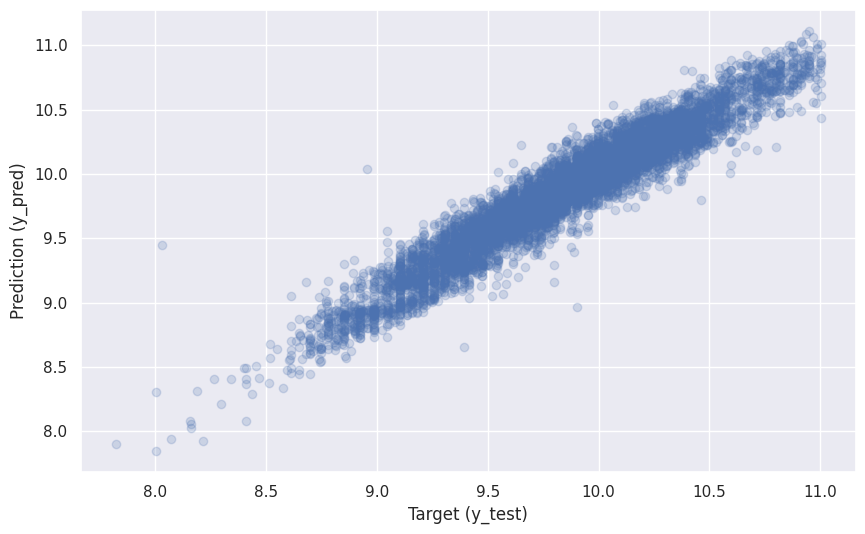

In [139]:
# valutiamo il modello su test set
y_pred = model1.predict(X_test)

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.2);

plt.xlabel('Target (y_test)');
plt.ylabel('Prediction (y_pred)');

In [140]:
# controlliamo l'RMSE sul test set
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))

3205.70917531565

Questo modello performa meglio del modello di regressione lineare.

Proviamo ora ad aggiungere un ulteriore strato.

In [141]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(64, activation='relu', input_shape=(8,)))
model2.add(keras.layers.Dense(32, activation='relu'))
model2.add(keras.layers.Dense(16, activation='relu'))
model2.add(keras.layers.Dense(1))

model2.compile(optimizer='adam', loss='mse')

model2.fit(X_train, y_train, epochs=20, validation_data=(X_val,y_val))

Epoch 1/20
744/744 [==============================] - 3s 3ms/step - loss: 5.8336 - val_loss: 0.1974
Epoch 2/20
744/744 [==============================] - 3s 4ms/step - loss: 0.1131 - val_loss: 0.0702
Epoch 3/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0550 - val_loss: 0.0472
Epoch 4/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0390 - val_loss: 0.0520
Epoch 5/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0325 - val_loss: 0.0293
Epoch 6/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0283 - val_loss: 0.0273
Epoch 7/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0248 - val_loss: 0.0286
Epoch 8/20
744/744 [==============================] - 2s 3ms/step - loss: 0.0242 - val_loss: 0.0359
Epoch 9/20
744/744 [==============================] - 3s 4ms/step - loss: 0.0224 - val_loss: 0.0207
Epoch 10/20
744/744 [==============================] - 2s 2ms/step - loss: 0.0215 - val_loss: 0.0201

In [142]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                576       
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


248/248 [==============================] - 0s 1ms/step


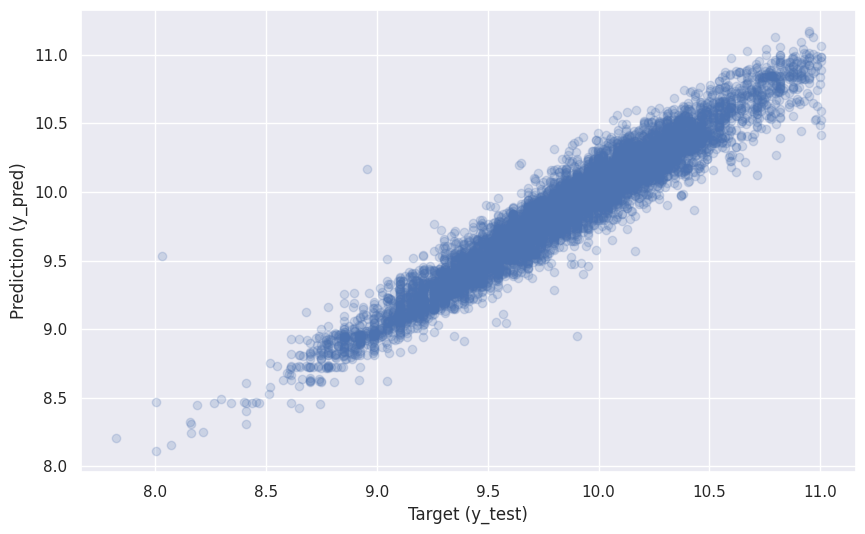

In [143]:
y_pred = model2.predict(X_test)

# tracciamo il grafico
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.2);

plt.xlabel('Target (y_test)');
plt.ylabel('Prediction (y_pred)');

In [144]:
# controlliamo l'RMSE sul test set
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))

3215.170758650473

Possiamo notare che in questo caso il modello è leggermente peggiorato.

# Conclusioni

Abbiamo analizzato e addestrato due modelli distinti per affrontare il problema proposto. Il primo modello, basato su un algoritmo di regressione lineare, ha mostrato una buona capacità di predizione con una semplicità computazionale che lo rende adatto per scenari con risorse limitate. Il secondo modello, un'implementazione di una rete neurale artificiale, ha dimostrato una maggiore accuratezza e capacità di catturare la complessità dei dati, sebbene a costo di una maggiore complessità computazionale.

Inoltre, è importante sottolineare che avremmo potuto migliorare ulteriormente i risultati modificando i parametri dei modelli, eliminando o aggiungendo attributi nel dataset, o sperimentando con diverse tecniche di feature engineering. Tali azioni avrebbero potuto fornire ulteriori insights su come ottimizzare le performance dei modelli.

Questo studio sottolinea l'importanza di considerare diversi approcci e di valutare i trade-off tra accuratezza e complessità nella selezione del modello più appropriato per un dato problema di machine learning.